# READMISSIONS PYTHON PROJECT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import(accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve)

## Data Cleaning

In [2]:
# importing file

file_path = "C:/Users/HP/Desktop/Portfolio_Projects/readmission_python/diabetic_data.csv"

df = pd.read_csv(file_path)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
# inspecting the structure

df.shape
df.info()
df['readmitted'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

In [4]:
(df == "?").sum().sort_values(ascending=False).head(15)

weight               98569
medical_specialty    49949
payer_code           40256
race                  2273
diag_3                1423
diag_2                 358
diag_1                  21
encounter_id             0
tolazamide               0
glyburide                0
tolbutamide              0
pioglitazone             0
rosiglitazone            0
acarbose                 0
miglitol                 0
dtype: int64

In [5]:
df = df.replace("?", np.nan)
df.isna().sum().sort_values(ascending=False).head(15)

weight               98569
max_glu_serum        96420
A1Cresult            84748
medical_specialty    49949
payer_code           40256
race                  2273
diag_3                1423
diag_2                 358
diag_1                  21
encounter_id             0
troglitazone             0
tolbutamide              0
pioglitazone             0
rosiglitazone            0
acarbose                 0
dtype: int64

In [6]:
df = df.drop(columns=["encounter_id", "patient_nbr"])

In [7]:
df["readmitted_binary"] = df["readmitted"].apply(lambda x: 1 if x == "<30" else 0)
df["readmitted_binary"].value_counts()

readmitted_binary
0    90409
1    11357
Name: count, dtype: int64

#### Droping extremely missing columns

In [8]:
df = df.drop(columns=[
    "weight",
    "max_glu_serum",
    "A1Cresult",
    "medical_specialty",
    "payer_code"
    
])

## Feature Engineering
- Total Visits Feature
- Elderly Risk Feature

In [9]:
df["total_visits"] = (
    df["number_outpatient"] +
    df["number_emergency"] +
    df["number_inpatient"]
)

df["elderly_flag"] = df["age"].apply(
    lambda x: 1 if x in ['[70-80)', '[80-90)',
    '[90-100)'] else 0
)

In [10]:
df.isna().sum().sort_values(ascending=False).head(10)

race             2273
diag_3           1423
diag_2            358
diag_1             21
tolbutamide         0
rosiglitazone       0
acarbose            0
miglitol            0
troglitazone        0
tolazamide          0
dtype: int64

### Removing Coulumns that will break the Model

In [11]:
df = df.drop(columns=[
    "readmitted",
    "discharge_disposition_id",
    "diag_1",
    "diag_2",
    "diag_3"
])

#### Separating Target and Features

In [12]:
y = df["readmitted_binary"]
X = df.drop(columns=[
    "readmitted_binary",
])

In [13]:
X.shape, y.shape

((101766, 40), (101766,))

#### Encoding Categorical Variables

In [14]:
X = pd.get_dummies(X, drop_first=True)

In [15]:
X.shape

(101766, 77)

## Modeling & Evaluation

#### Train Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
)

y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

readmitted_binary
0    0.888425
1    0.111575
Name: proportion, dtype: float64

#### Logistic Regression

In [17]:
log_model = LogisticRegression(max_iter=1000, solver="liblinear")
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

# Evaluating
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_log))

Accuracy: 0.8885231404146605

Classification Report:

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.52      0.01      0.03      2271

    accuracy                           0.89     20354
   macro avg       0.70      0.51      0.48     20354
weighted avg       0.85      0.89      0.84     20354



#### Confusion Matrix

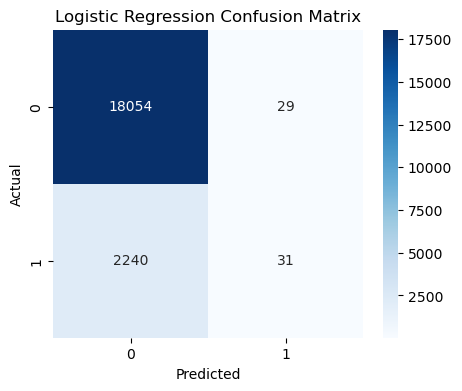

In [18]:
cm = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

#### ROC Curve (probability-based)

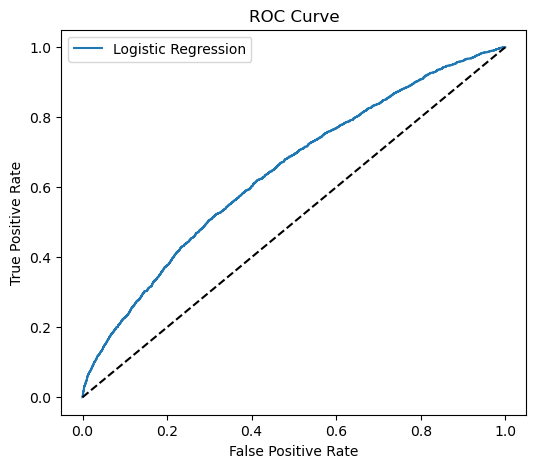

ROC AUC:  0.6420239975203142


In [19]:
y_prob = log_model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label= "Logistic Regression")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC: ", roc_auc)

### Exporting Predictions to CSV

In [20]:
X_test_copy = X_test.copy()
X_test_copy["actual_readmit"] = y_test
X_test_copy["predicted_readmit"] = y_pred_log
X_test_copy["risk_score"] = y_prob

X_test_copy.to_csv("C:/Users/HP/Desktop/Portfolio_Projects/readmission_python/logreg_predictions.csv", index=False)

### Decision Tree Model

In [21]:
dt_model = DecisionTreeClassifier(
    max_depth=5,
    random_state=42
)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [22]:
y_pred_dt = dt_model.predict(X_test)
y_prob_dt = dt_model.predict_proba(X_test)[:,1]

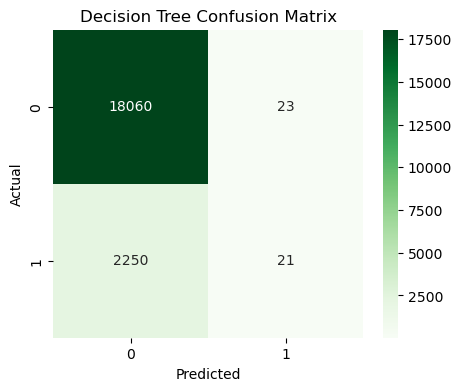

In [23]:
cm = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree Confusion Matrix")
plt.show()

#### ROC AUC

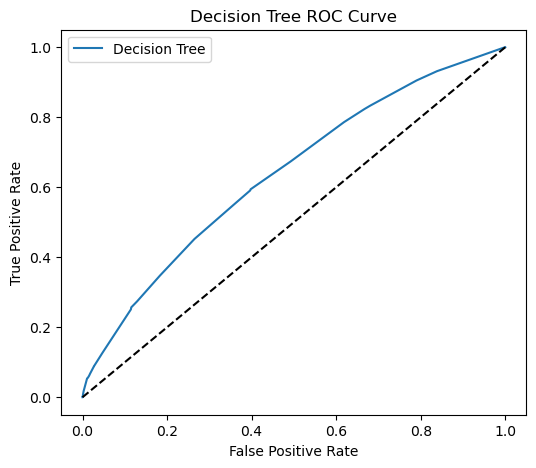

Decision Tree ROC AUC:  0.6370199666185277


In [24]:
y_prob_dt = dt_model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob_dt)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label= "Decision Tree")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree ROC Curve")
plt.legend()
plt.show()

roc_auc_dt = roc_auc_score(y_test, y_prob_dt)
print("Decision Tree ROC AUC: ", roc_auc_dt)

#### Feature Importance (Clinical Insight)

C:\Users\HP\AppData\Local\Temp\ipykernel_6404\3036642632.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")


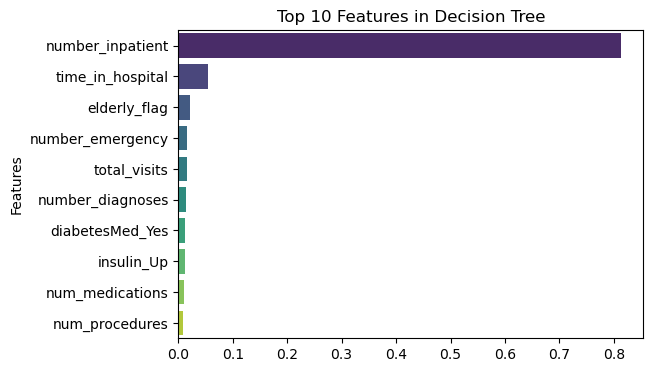

In [25]:
feat_imp = pd.Series(dt_model.feature_importances_,index=X.columns)
feat_imp = feat_imp.sort_values(ascending=False).head(10)

plt.figure(figsize=(6,4))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")
plt.title("Top 10 Features in Decision Tree")
plt.ylabel("Features")
plt.show()

### Exporting Predictions to CSV

In [26]:
X_test_dt = X_test.copy()
X_test_dt["actual_readmit"] = y_test
X_test_dt["predicted_readmit"] = y_pred_dt
X_test_dt["risk_score"] = y_prob_dt

X_test_dt.to_csv("C:/Users/HP/Desktop/Portfolio_Projects/readmission_python/decision_tree_predictions.csv", index=False)